In [207]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import minimize

In [208]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
           'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
data = pd.read_csv(url, names=columns, na_values="?")


In [209]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [210]:
data = data.dropna()
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

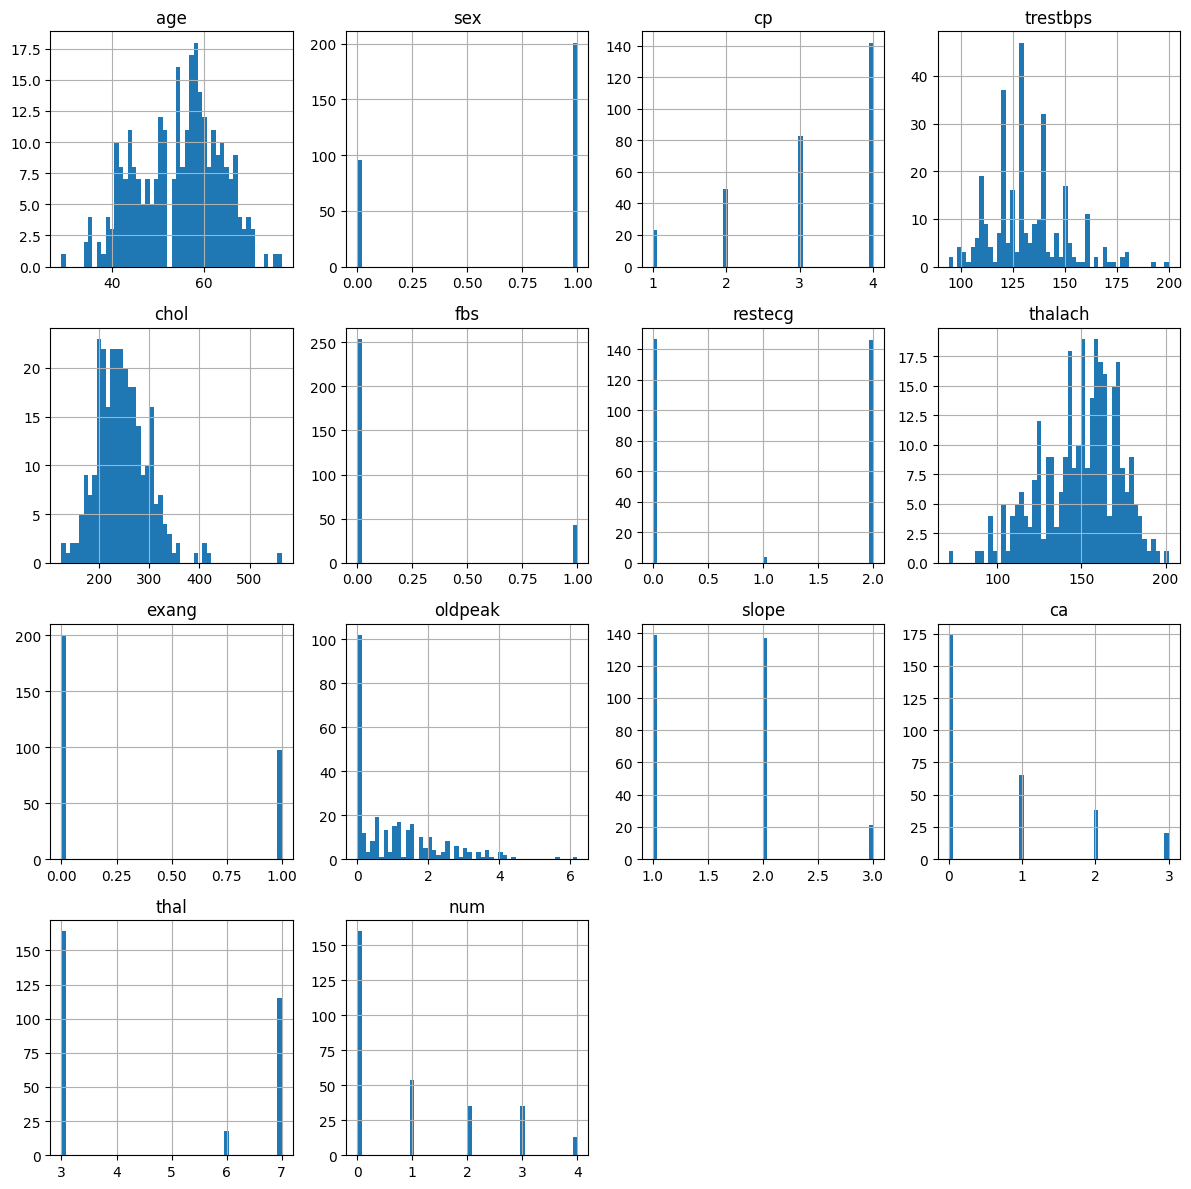

In [220]:
data.hist(bins = 50, figsize=(12,12))
plt.tight_layout()
plt.show()

<Axes: >

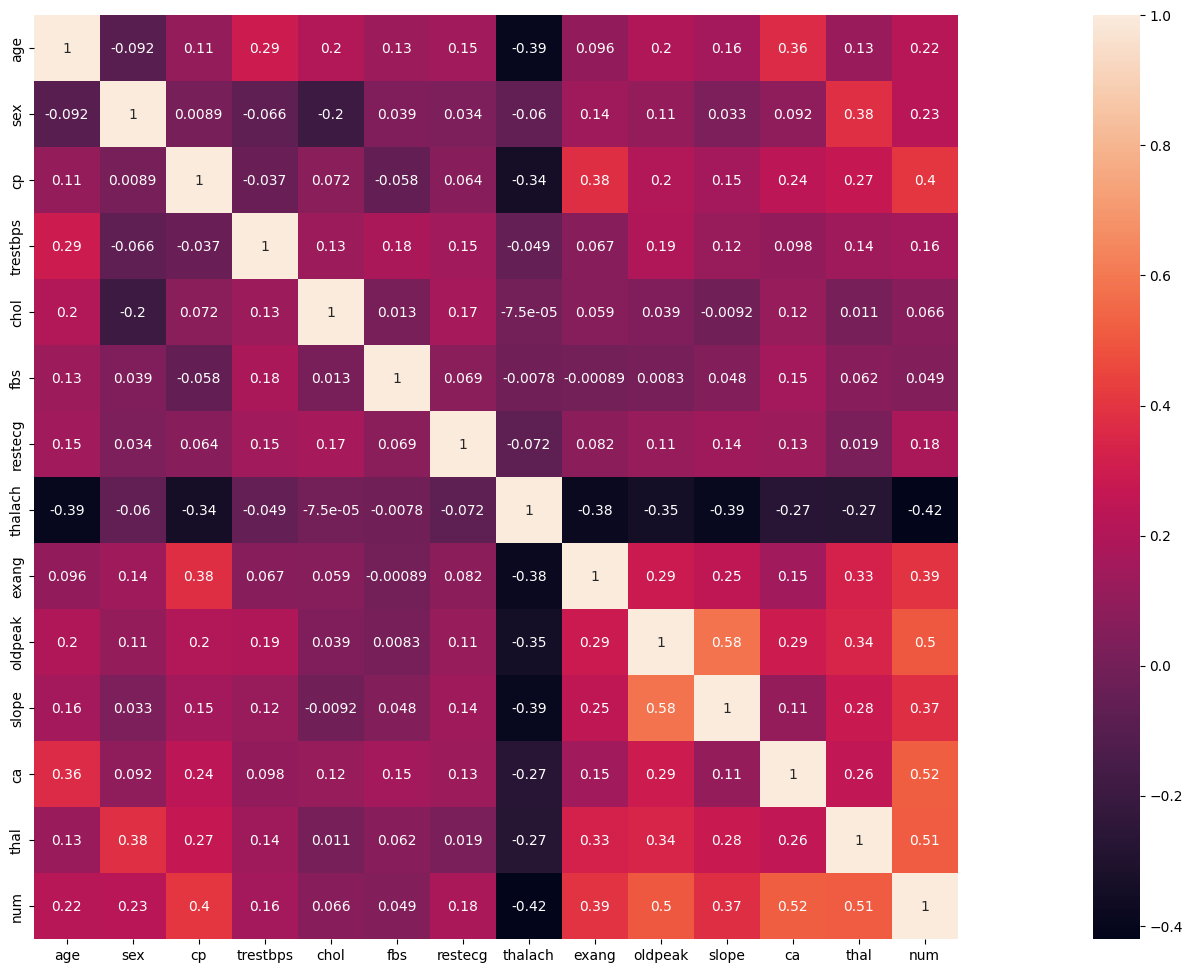

In [212]:
corr = data.corr(numeric_only=True)

fig, ax = plt.subplots(figsize = (16,12))
fig.set_size_inches(35,12)
sns.heatmap(corr,square=True, annot=True)

In [213]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost (loss) function for logistic regression
def cost_function(weights, X, y):
    m = len(y)
    h = sigmoid(X @ weights)
    cost = -(1/m) * np.sum(y * np.log(h + 1e-10) + (1 - y) * np.log(1 - h + 1e-10))
    return cost

# Gradient of the cost function
def gradient(weights, X, y):
    m = len(y)
    h = sigmoid(X @ weights)
    return (1/m) * X.T @ (h - y)

In [214]:
# Preprocess the dataset
X = data.drop(columns=['num']).values
y = (data['num'] > 0).astype(int).values  # Binary target: 0 = no heart disease, 1 = heart disease

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add bias term (intercept)
X_scaled = np.c_[np.ones(X_scaled.shape[0]), X_scaled]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Initialize results
results = []

# Function to evaluate and plot confusion matrix
def evaluate_model(method_name, weights, y_test, X_test):
    y_pred = (sigmoid(X_test @ weights) >= 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"{method_name} Accuracy: {acc:.4f}")
    ConfusionMatrixDisplay(conf_matrix).plot()
    plt.title(f"Confusion Matrix for {method_name}")
    return acc


In [215]:
# BFGS Optimization using Scipy's minimize
def bfgs_optimization(X, y):
    """
    Perform BFGS optimization to minimize the logistic regression cost function.

    Parameters:
    X -- Feature matrix
    y -- Target values

    Returns:
    weights -- Optimized weights after BFGS optimization
    iterations -- Number of iterations performed
    """
    n_features = X.shape[1]
    initial_weights = np.zeros(n_features)

    # Perform optimization using BFGS method
    result = minimize(fun=cost_function, x0=initial_weights, args=(X, y),
                      method='BFGS', jac=gradient, options={'disp': True})
    
    # Return the optimized weights and the number of iterations
    return result.x, result.nit

# Conjugate Gradient Descent Implementation
def conjugate_gradient_descent(X, y, tol=1e-5, max_iter=1000):
    """
    Perform Conjugate Gradient Descent optimization for logistic regression.

    Parameters:
    X -- Feature matrix
    y -- Target values
    tol -- Convergence tolerance (default: 1e-5)
    max_iter -- Maximum number of iterations (default: 1000)

    Returns:
    weights -- Optimized weights after Conjugate Gradient Descent
    iterations -- Number of iterations performed
    """
    # Initialize weights and compute initial gradient
    weights = np.zeros(X.shape[1])
    grad = gradient(weights, X, y)
    direction = -grad  # Initial search direction
    
    for i in range(max_iter):
        # Calculate the new gradient and the Polak-Ribiere-Polyak (PRP) beta
        grad_new = gradient(weights, X, y)
        beta = np.dot(grad_new, grad_new) / np.dot(grad, grad)
        
        # Update direction based on the new gradient and previous direction
        direction = -grad_new + beta * direction
        
        # Perform line search (step size calculation using a simple method)
        alpha = -np.dot(grad, direction) / np.dot(direction, X.T @ (X @ direction))
        
        # Update weights
        weights += alpha * direction
        
        # Check convergence based on gradient norm
        if np.linalg.norm(grad_new) < tol:
            return weights, i + 1
        
        # Update the gradient for the next iteration
        grad = grad_new
    
    # Return the optimized weights and the number of iterations
    return weights, max_iter

Optimization terminated successfully.
         Current function value: 0.364636
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
BFGS Accuracy: 0.8800
Conjugate Gradient Accuracy: 0.9067
Comparison of Optimization Techniques
Method                         Accuracy   Iterations Time (s)  
BFGS                           0.8800     34         0.0061    
Conjugate Gradient             0.9067     1000       0.0223    


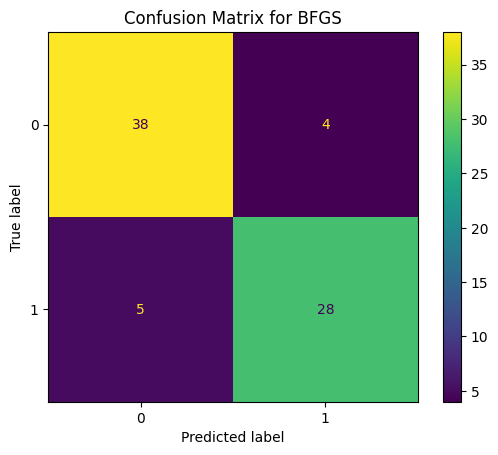

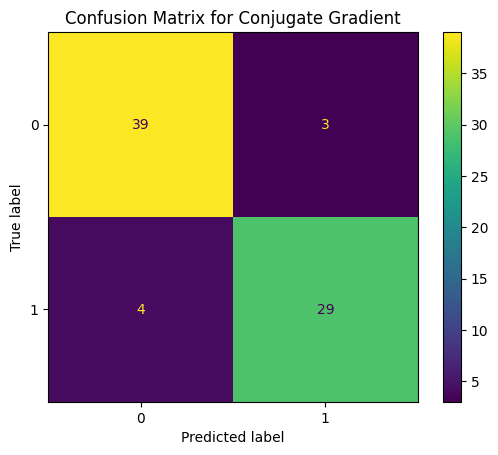

In [216]:

# Comparing Methods
results = []

# BFGS Optimization
start_time = time.time()
weights_bfgs, iterations_bfgs = bfgs_optimization(X_train, y_train)
time_bfgs = time.time() - start_time
accuracy_bfgs = evaluate_model("BFGS", weights_bfgs, y_test, X_test)
results.append(("BFGS", accuracy_bfgs, iterations_bfgs, time_bfgs))

# CGD Optimization
start_time = time.time()
weights_cgd, iterations_cgd = conjugate_gradient_descent(X_train, y_train)
time_cgd = time.time() - start_time
accuracy_cgd = evaluate_model("Conjugate Gradient", weights_cgd, y_test, X_test)
results.append(("Conjugate Gradient", accuracy_cgd, iterations_cgd, time_cgd))

# Display results
print("Comparison of Optimization Techniques")
print(f"{'Method':<30} {'Accuracy':<10} {'Iterations':<10} {'Time (s)':<10}")
for method, acc, iters, t in results:
    print(f"{method:<30} {acc:<10.4f} {iters:<10} {t:<10.4f}")

plt.show()
